In [1]:
import numpy as np
from nptyping import NDArray
import random
import numpy.linalg as LA
import matplotlib.pyplot as plt
from typing import List, Set, Dict, Tuple, Optional, Any, Callable
from PIL import Image
import os
import json

np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
from utils import load_image_to_arr, display_rgb, SVD2D
import dim_reduction
from spectral_data import ImageSpectralData
dim_reduction.init_basis_cache()
import cityscapes_helper
from dataset_creation import (
    MultiScaleImageSampler, 
    ImageChunkSummarizerOptions, 
    MultiScaleImageEncoder, 
    MultiScaleImageDecoder,
    MultiScaleMultiResolutionImageSampler,
    DownsampledImageAtScale,
    ImageAtScale, 
    CityscapesDatasetFactory, 
    WholeImage,
    CityScapesDataset,
    semantic_image_composition
)
from image_segmentation import (
    semantic_composition_grid,
    feature_grid,
    predict_semantic_grid
)
from cityscapes_helper import format_semantic_composition

In [3]:
# Ben Desptop
#cityscapes_helper.set_visual_data_zip_path("C:\\Users\\Ben\\Downloads\\leftImg8bit_trainvaltest.zip")
#cityscapes_helper.set_semantic_data_zip_path("C:\\Users\\Ben\\Downloads\\gtFine_trainvaltest.zip")

#Ben Laptop (via WSL)
cityscapes_helper.set_visual_data_zip_path("/mnt/c/Users/benki/Downloads/leftImg8bit_trainvaltest.zip")
cityscapes_helper.set_semantic_data_zip_path("/mnt/c/Users/benki/Downloads/gtFine_trainvaltest.zip")

cityscapes_helper.initialize_tool()

In [8]:
scales = [240, 96, 32]

whole_img_options = ImageChunkSummarizerOptions()
whole_img_options.downsample_factor = 8
whole_img_options.n_pcm_coeffs = [80, 40, 30]

opt_240 = ImageChunkSummarizerOptions()
opt_240.downsample_factor = 3
opt_240.n_pcm_coeffs = [120, 40, 20]

opt_96 = ImageChunkSummarizerOptions()
opt_96.downsample_factor = 2
opt_96.n_pcm_coeffs = [120, 40, 20]

opt_32 = ImageChunkSummarizerOptions()
opt_32.downsample_factor = 1
opt_32.n_pcm_coeffs = [60, 20, 15]

chunk_summarizer_options = [whole_img_options, opt_240, opt_96, opt_32]
downsample_factors = [3, 2, 1]

multiscaleEncoder = MultiScaleImageEncoder(chunk_summarizer_options)

cologne_000100


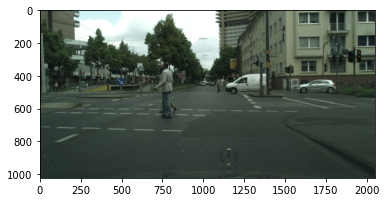

In [9]:
#(scene_id, (vis, sem)) = cityscapes_helper.loadRandomScene()
scene_id = "cologne_000100"
vis = cityscapes_helper.loadVisualInfo(scene_id)
print(scene_id)
display_rgb(vis)

(24, 56, 30)


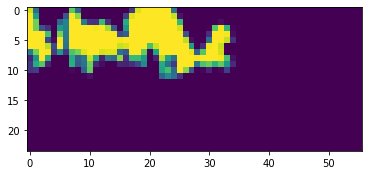

In [10]:
cologne_semantic_grid = semantic_composition_grid(scene_id, scales)
print(cologne_semantic_grid.shape)

class_index = 21 #above-ground folliage
foliage_semantic_map = cologne_semantic_grid[:, :, class_index]
fig, ax = plt.subplots()
ax.imshow(foliage_semantic_map)

In [14]:
cologne_feature_grid = feature_grid(scene_id, multiscaleEncoder, scales, downsample_factors)
cologne_feature_grid.shape

(24, 56, 701)

In [12]:
from sklearn.neighbors import KNeighborsClassifier

dataset = CityScapesDataset("full_dataset_v1_30000")
dataset.load()

#Select the mean color of the smallest/core chunk
toy_feature_subset = [(3, 'mean')]
toy_feature_mask = dataset.get_feature_subset_mask(toy_feature_subset)
tiny_features = dataset.features[:, toy_feature_mask]
tiny_features_normalized = dataset.get_normalized_features()[:, toy_feature_mask]
print(tiny_features_normalized.shape)

#figure out which ones are mostly foliage
foliage_index = 21
foliage_composition = dataset.labels[:, foliage_index]
majority_foliage_mask = foliage_composition > 0.5

folliage_nn_classifier = KNeighborsClassifier(3).fit(tiny_features_normalized, majority_foliage_mask)

def folage_nn_prediction_function(normalized_feature: NDArray[Any]):
    toy_feature = normalized_feature[toy_feature_mask]
    pred_is_foliage = folliage_nn_classifier.predict(toy_feature.reshape(1, -1))[0]
    result = np.zeros(30)
    if(pred_is_foliage):
        result[21] = 1.0
    return result

0.npy,1.npy,2.npy,3.npy,4.npy,5.npy,6.npy,
(30000, 3)


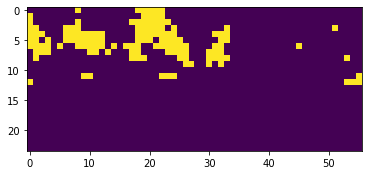

In [13]:
R = predict_semantic_grid(cologne_feature_grid, dataset, True, folage_nn_prediction_function)
foliage_semantic_map = R[:, :, 21]
fig, ax = plt.subplots()
ax.imshow(foliage_semantic_map)